# 02 — Monte Carlo pricing, standard error, and variance reduction

This demo shows how to use the library's Monte Carlo (MC) pricer for European options under GBM, how to interpret the **standard error** (SE), and how to reduce variance with:

- **Antithetic variates** (cheap, broadly applicable)
- **Control variates** (powerful when a good control is available)

> The goal is practical: get a price **and** a defensible uncertainty estimate.


## Imports and setup

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

from option_pricing import (
    MarketData,
    OptionSpec,
    OptionType,
    PricingInputs,
    bs_price,
    mc_price,
)
from option_pricing.vanilla import make_vanilla_payoff

# Optional utilities (nice plots/tables for this demo).
# If your local package doesn't ship these yet, the demo still runs.
try:
    from option_pricing.models.stochastic_processes import sim_gbm_terminal
except Exception:
    sim_gbm_terminal = None

try:
    from option_pricing.diagnostics.gbm_diagnostics import plot_gbm_terminal_dists
except Exception:
    plot_gbm_terminal_dists = None

try:
    from option_pricing.diagnostics.mc_vs_bs import (
        compare_table,
        convergence_table,
        default_cases,
    )
    from option_pricing.diagnostics.mc_vs_bs_plots import (
        plot_mc_bs_errorbars,
        plot_se_scaling,
    )
except Exception:
    default_cases = compare_table = convergence_table = None
    plot_mc_bs_errorbars = plot_se_scaling = None

# Variance reduction hooks (may be introduced after the first version of the library).
try:
    from option_pricing.pricers.mc import ControlVariate, McGBMModel
except Exception:
    McGBMModel = ControlVariate = None

pd.set_option("display.precision", 6)


## Define a pricing scenario

In [13]:
market = MarketData(spot=100.0, rate=0.02, dividend_yield=0.00)
spec_call = OptionSpec(kind=OptionType.CALL, strike=100.0, expiry=1.0)

# PricingInputs is the library's "single object" that ties together market + spec + model params.
p_call = PricingInputs(spec=spec_call, market=market, sigma=0.20, t=0.0)

p_call


PricingInputs(spec=OptionSpec(kind=<OptionType.CALL: 'call'>, strike=100.0, expiry=1.0), market=MarketData(spot=100.0, rate=0.02, dividend_yield=0.0), sigma=0.2, t=0.0)

## Monte Carlo price and uncertainty

The MC pricer returns:

- **price**: discounted sample mean of the payoff
- **standard error (SE)**: estimated uncertainty of the MC mean

A 95% confidence interval is approximately `price ± 1.96 * SE`.


In [14]:
N = 200_000
seed = 0

mc_est, mc_se = mc_price(p_call, n_paths=N, seed=seed)
bs = bs_price(p_call)

z = 1.96  # ~95% CI
ci_low, ci_high = mc_est - z * mc_se, mc_est + z * mc_se

print(f"MC estimate : {mc_est:.6f}")
print(f"MC SE       : {mc_se:.6f}")
print(f"95% CI      : [{ci_low:.6f}, {ci_high:.6f}]")
print(f"BS price    : {bs:.6f}")
print(f"BS inside CI? {ci_low <= bs <= ci_high}")


MC estimate : 8.929248
MC SE       : 0.030874
95% CI      : [8.868735, 8.989761]
BS price    : 8.916037
BS inside CI? True


## Optional sanity check: simulated terminal distribution

Under GBM, the terminal distribution of `S_T` is lognormal. This plot is optional (and depends on the diagnostics helper).


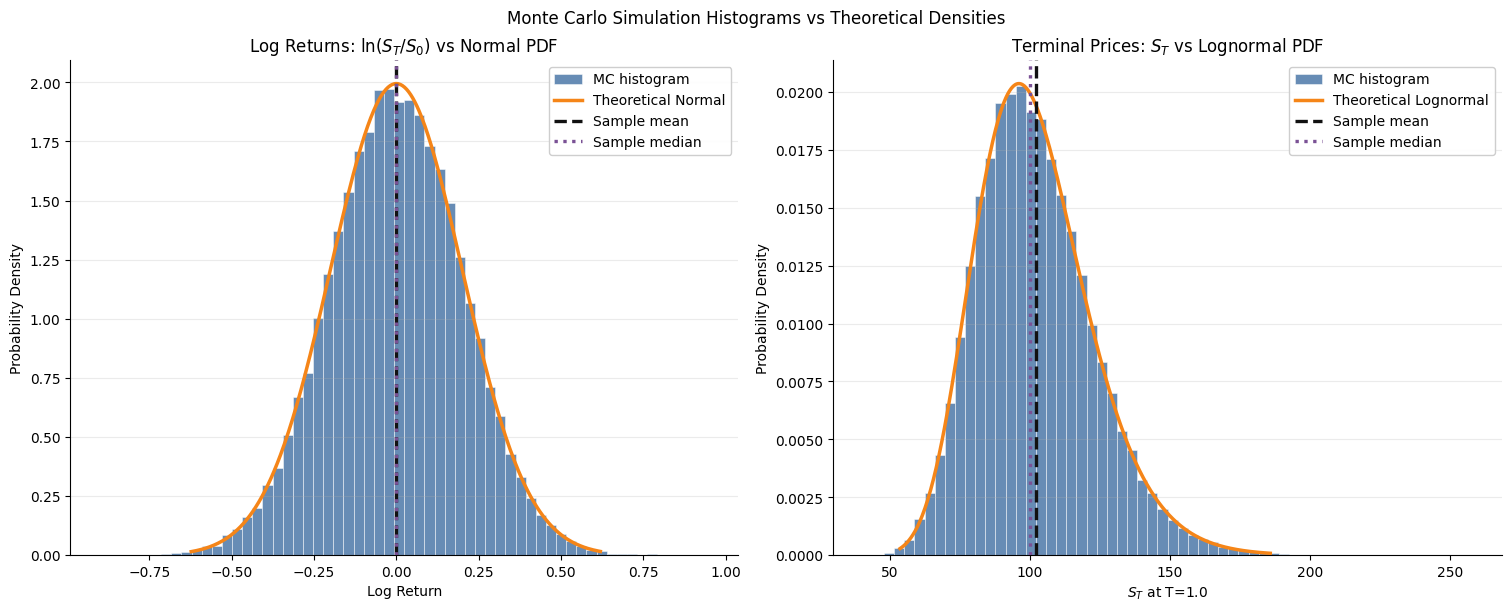

In [15]:
if sim_gbm_terminal is None or plot_gbm_terminal_dists is None:
    print("Skipping: sim_gbm_terminal/plot_gbm_terminal_dists not available in this environment.")
else:
    n_paths = 50_000
    rng = np.random.default_rng(0)  # reproducible

    # Under risk-neutral pricing, drift is r - q (continuous dividend yield).
    mu_rn = p_call.r - p_call.q
    S_T = sim_gbm_terminal(
        n_paths=n_paths,
        T=p_call.tau,
        mu=mu_rn,
        sigma=p_call.sigma,
        S0=p_call.S,
        rng=rng,
    )

    fig, axes = plot_gbm_terminal_dists(
        S_T,
        S0=p_call.S,
        r=p_call.r,
        sigma=p_call.sigma,
        T=p_call.tau,
        bins=60,
        show_mean=True,
        show_median=True,
    )


## Standard error scaling

For plain Monte Carlo, the SE should decrease roughly like **1 / sqrt(N)**.


,n_paths,MC,SE,BS,MC-BS,abs_err,tau,kind,q
0,1000,8.103511,0.408756,8.916037,-0.812526,0.812526,1.0,call,0.0
1,2000,8.608258,0.298089,8.916037,-0.307779,0.307779,1.0,call,0.0
2,5000,8.888904,0.193488,8.916037,-0.027133,0.027133,1.0,call,0.0
3,10000,8.993184,0.136756,8.916037,0.077146,0.077146,1.0,call,0.0
4,20000,8.951532,0.096822,8.916037,0.035494,0.035494,1.0,call,0.0
5,50000,8.948660,0.061770,8.916037,0.032623,0.032623,1.0,call,0.0
6,100000,8.905244,0.043591,8.916037,-0.010793,0.010793,1.0,call,0.0


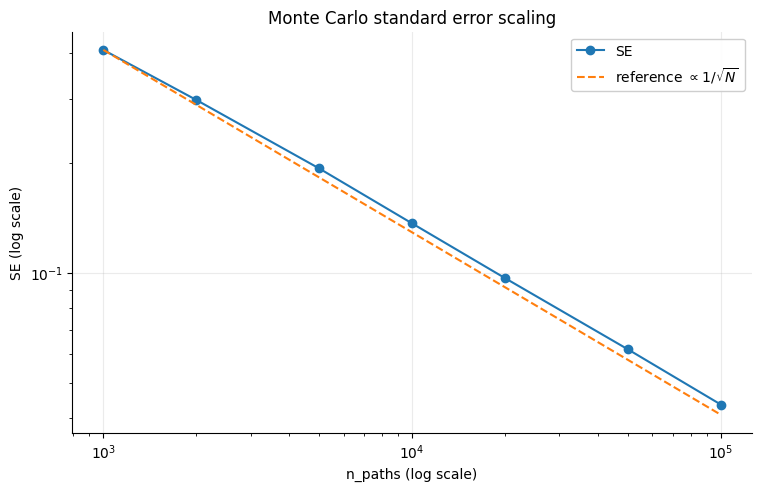

In [16]:
if convergence_table is None or plot_se_scaling is None:
    # Lightweight fallback if the diagnostics module isn't present.
    n_paths_list = np.array([1_000, 2_000, 5_000, 10_000, 20_000, 50_000, 100_000], dtype=int)
    rows = []
    for n in n_paths_list:
        est, se = mc_price(p_call, n_paths=int(n), seed=0)
        rows.append((int(n), float(est), float(se)))
    df_conv = pd.DataFrame(rows, columns=["n_paths", "mc_price", "mc_se"])
    display(df_conv)

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(df_conv["n_paths"], df_conv["mc_se"])
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Number of paths N (log scale)")
    ax.set_ylabel("Standard error (log scale)")
    ax.set_title("MC standard error vs N")
    ax.grid(True, which="both", ls=":")
else:
    df_conv = convergence_table(
        p_call,
        n_paths_list=(1_000, 2_000, 5_000, 10_000, 20_000, 50_000, 100_000),
        seed=0,
    )
    display(df_conv)
    fig, ax = plot_se_scaling(df_conv)


## MC vs BS across a small grid of cases

A quick “health check” across a few moneyness / vol / maturity settings. The error bars are 95% CIs around the MC estimate.


,case,kind,t,S,K,r,q,sigma,T,tau,...,MC,SE,BS,MC-BS,rel_err,z,abs_z,CI_low,CI_high,BS_in_CI
0,High vol (80%),call,0.0,100.0,100.0,0.02,0.00,0.80,1.000000,1.000000,...,31.004478,0.482497,31.775774,-0.771295,-0.024273,-1.598550,1.598550,30.058785,31.950172,True
1,ITM (S=120),call,0.0,120.0,100.0,0.02,0.00,0.20,1.000000,1.000000,...,23.934369,0.138552,23.742105,0.192264,0.008098,1.387671,1.387671,23.662808,24.205931,True
2,High rate (10%),call,0.0,100.0,100.0,0.10,0.00,0.20,1.000000,1.000000,...,13.380747,0.102534,13.269677,0.111071,0.008370,1.083255,1.083255,13.179780,13.581714,True
3,Long tau (5y),call,0.0,100.0,100.0,0.02,0.00,0.20,5.000000,5.000000,...,21.795056,0.233737,22.022087,-0.227030,-0.010309,-0.971308,0.971308,21.336932,22.253180,True
4,Deep OTM (S=50),call,0.0,50.0,100.0,0.02,0.00,0.20,1.000000,1.000000,...,0.000941,0.000482,0.001379,-0.000438,-0.317563,-0.908600,0.908600,-0.000004,0.001886,True
5,Low vol (5%),call,0.0,100.0,100.0,0.02,0.00,0.05,1.000000,1.000000,...,3.103686,0.022926,3.120691,-0.017006,-0.005449,-0.741763,0.741763,3.058751,3.148621,True
6,Dividend (q=2%),call,0.0,100.0,100.0,0.02,0.02,0.20,1.000000,1.000000,...,7.757663,0.080646,7.807839,-0.050176,-0.006426,-0.622177,0.622177,7.599597,7.915728,True
7,ATM base,call,0.0,100.0,100.0,0.02,0.00,0.20,1.000000,1.000000,...,8.956747,0.087263,8.916037,0.040710,0.004566,0.466523,0.466523,8.785713,9.127782,True
8,Deep ITM (S=150),call,0.0,150.0,100.0,0.02,0.00,0.20,1.000000,1.000000,...,52.055511,0.190275,52.124969,-0.069458,-0.001333,-0.365042,0.365042,51.682571,52.428450,True
9,Short tau (1w),call,0.0,100.0,100.0,0.02,0.00,0.20,0.019231,0.019231,...,1.128685,0.010476,1.125552,0.003133,0.002783,0.299049,0.299049,1.108152,1.149217,True


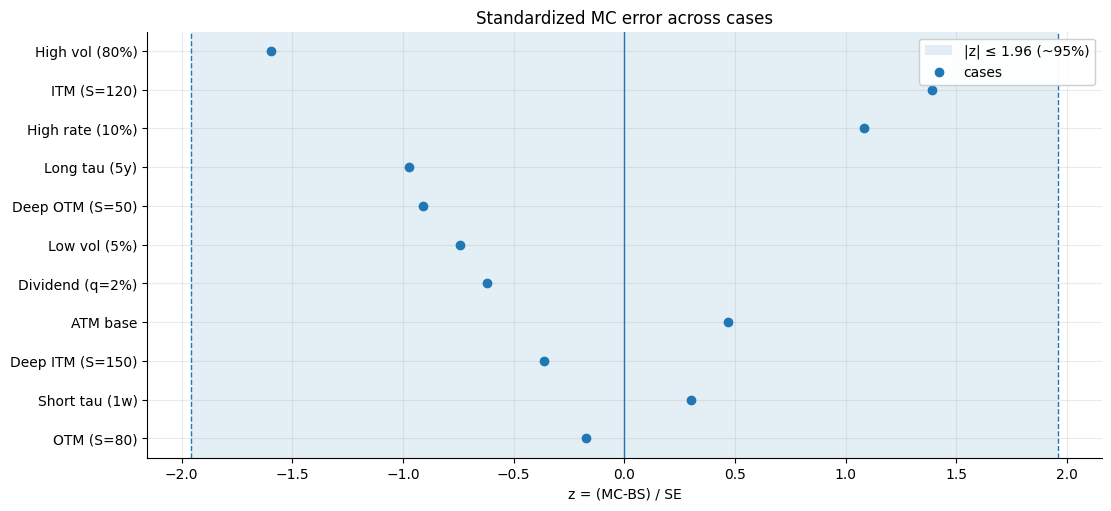

In [17]:
if default_cases is None or compare_table is None or plot_mc_bs_errorbars is None:
    print("Skipping: mc_vs_bs diagnostics helpers not available in this environment.")
else:
    cases = default_cases(p_call)  # list[(label, PricingInputs)]
    df_mc_vs_bs = compare_table(
        cases,
        n_paths=25_000,
        seed=123,
        per_case_seed=True,
    )
    display(df_mc_vs_bs)
    fig, ax = plot_mc_bs_errorbars(df=df_mc_vs_bs, figsize=(11, 5))


## Variance reduction: antithetic variates

Antithetic variates reuse the same random shocks `Z` and `-Z`. For many monotone payoffs (like calls/puts), this typically reduces variance at almost no extra cost.

This section uses the **public** `mc_price(..., antithetic=True)` API if available.


In [18]:
import inspect


def _summarize(label: str, price: float, se: float | None = None) -> str:
    if se is None:
        return f"{label:<14} {price:>12.6f}"
    ci = 1.96 * se
    return f"{label:<14} {price:>12.6f}   SE={se:>9.6f}   95% CI=±{ci:>9.6f}"

sig = inspect.signature(mc_price)
supports_antithetic = "antithetic" in sig.parameters

N = 100_000
seed = 0

plain_price, plain_se = mc_price(p_call, n_paths=N, seed=seed)

if supports_antithetic:
    anti_price, anti_se = mc_price(p_call, n_paths=N, seed=seed, antithetic=True)
    print(_summarize("MC (plain)", plain_price, plain_se))
    print(_summarize("MC (anti)", anti_price, anti_se))

    speedup = (plain_se / anti_se) ** 2 if anti_se > 0 else np.inf
    print(f"Effective speedup from antithetic ≈ {speedup:.2f}x (same N, lower SE)")
else:
    print("This build of mc_price does not expose antithetic=True yet.")
    print(_summarize("MC (plain)", plain_price, plain_se))


MC (plain)         8.905244   SE= 0.043591   95% CI=± 0.085439
MC (anti)          8.940474   SE= 0.033336   95% CI=± 0.065338
Effective speedup from antithetic ≈ 1.71x (same N, lower SE)


## Variance reduction: control variate using `S_T`

A control variate uses a correlated random variable `Y` with **known mean** `E[Y]`.  
Here we use:

- `X = payoff(S_T)`
- `Y = S_T`
- `E[S_T] = S0 * exp((r - q) * T)` under the risk-neutral GBM drift

This is a **generic** control that works for any payoff that depends on `S_T`. The improvement depends on correlation.


In [19]:
# --- Control variate demo (CV on ST) ---

# Build the model explicitly so we can pass a ControlVariate to price_european.
model = McGBMModel(
    S0=p_call.S,
    r=p_call.r,
    q=p_call.q,
    sigma=p_call.sigma,
    tau=p_call.tau,
    n_paths=N,
    antithetic=False,
    rng=np.random.default_rng(seed),
)

# Use the shared payoff factory (no lambdas; Ruff-friendly)
payoff = make_vanilla_payoff(p_call.spec.kind, K=p_call.K)

# Control variate: Y = ST, with known mean under risk-neutral GBM
control_ST = ControlVariate(
    values=np.asarray,  # identity on ST (ensures ndarray)
    mean=p_call.S * np.exp((p_call.r - p_call.q) * p_call.tau),
)

cv_price, cv_se = model.price_european(payoff, control=control_ST)

print(_summarize("Black-Scholes", bs, None))
print(_summarize("MC (plain)", plain_price, plain_se))
print(_summarize("MC + CV(ST)", cv_price, cv_se))

speedup = (plain_se / cv_se) ** 2 if cv_se > 0 else np.inf
print(f"\nEffective speedup from CV(ST) ≈ {speedup:.2f}x (same N, lower SE)")


Black-Scholes      8.916037
MC (plain)         8.905244   SE= 0.043591   95% CI=± 0.085439
MC + CV(ST)        8.916440   SE= 0.018581   95% CI=± 0.036419

Effective speedup from CV(ST) ≈ 5.50x (same N, lower SE)


## Summary

- Monte Carlo returns a price **and** a standard error; use `price ± 1.96·SE` as an approximate 95% confidence interval.
- SE should scale like `1/sqrt(N)`; if it doesn't, double-check the estimator and random seeding.
- Antithetic variates are a cheap first-line variance reducer.
- Control variates can be very effective when you have a correlated variable with a known expectation (e.g., `S_T` under GBM).
